In [1]:
import pickle
from quests_data import *

import itertools
import seaborn as sns
from ase.io import read
from quests.tools.plotting import savefig, COLORS
import lammps_logfile as lmp
from scipy import stats
from scipy.optimize import curve_fit

def clean_filename(name):
    return name.split("/")[-1].strip(".xyz")

def get_nums(name):
    return int(re.findall("[0-9]+", name)[0])

ROOT_DIR = "../data/05-Cu"

## Load the data

In [2]:
H = pd.read_csv(f"{ROOT_DIR}/entropies.csv", index_col=0)
H["time"] = H["traj"] * 10

In [3]:
dH = pd.read_csv(f"{ROOT_DIR}/dH.csv", index_col=0)

In [4]:
grp = dH.groupby("traj")
mdH = grp["dH"].mean()
sdH = grp["dH"].std()
traj = np.arange(0, 200)
time = traj * 10

In [5]:
logfile = lmp.File(f"{ROOT_DIR}/log.lammps")
log = pd.DataFrame(logfile.data_dict)

In [6]:
with open(f"{ROOT_DIR}/cnt/nuclei.pkl", "rb") as f:
    cnt = pickle.load(f)
    
cnt_df = pd.read_csv(f"{ROOT_DIR}/cnt/nuclei_sizes.csv", index_col=0)

max_n = np.array([
    n.max() for n in cnt.values()
])

## Plotting the figures

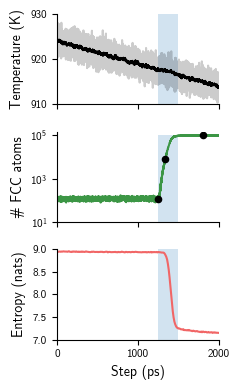

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(2.5, 4.0), sharex=True)

ax = axs[0]
_df = log.rolling(window=50).mean()

ylim = [910, 930]
ax.fill_between([1250, 1500], [ylim[0], ylim[0]], [ylim[1], ylim[1]], alpha=0.2, zorder=-2)

ax.plot(log["Time"], log["Temp"], "k-", alpha=0.2)
ax.plot(_df["Time"], _df["Temp"], "k-")

ax.set_xlim(0, 2001)
ax.set_ylim(ylim)
ax.set_yticks([910, 920, 930])
ax.set_ylabel("Temperature (K)")

ax = axs[1]
_df = log
ax.plot(_df["Time"], _df["c_cna_tot01"], color=COLORS["fcc"])

_df2 = _df.loc[_df["Time"] == 1250.0]
ax.scatter(_df2["Time"], _df2["c_cna_tot01"], s=20, c="k", zorder=3)

_df2 = _df.loc[_df["Time"] == 1340.0]
ax.scatter(_df2["Time"], _df2["c_cna_tot01"], s=20, c="k", zorder=3)

_df2 = _df.loc[_df["Time"] == 1800.0]
ax.scatter(_df2["Time"], _df2["c_cna_tot01"], s=20, c="k", zorder=3)

ax.fill_between([1250, 1500], [1e5, 1e5], alpha=0.2)
ax.set_yscale("log")
ax.set_ylabel("# FCC atoms")
ax.set_yticks([1e1, 1e3, 1e5])

ax = axs[2]
ax.plot(H["time"], H["entropy"], color=COLORS["hcp"])
ax.fill_between([1250, 1500], [7.0, 7.0], [9.0, 9.0], alpha=0.2)
ax.set_ylim(7, 9)

ax.set_ylabel("Entropy (nats)")
ax.set_xlabel("Step (ps)")


fig.tight_layout()
# savefig(fig, "03-solid-curves.pdf")
plt.show()

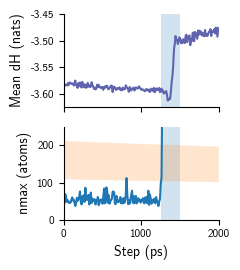

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(2.5, 2.8), sharex=True)

ax = axs[0]

ylim = [-3.625, -3.450]
ax.plot(time[1:], mdH.iloc[1:], color=COLORS["bcc"])
ax.fill_between([1250, 1500], [ylim[0], ylim[0]], [ylim[1], ylim[1]], alpha=0.2)
ax.set_ylim(*ylim)

ax.set_ylabel("Mean dH (nats)")

ax.set_xlim(0, 2001)

ax = axs[1]

NMAX = 500
frames = np.arange(len(max_n))
mask = max_n < NMAX

ax.plot(frames[mask] * 10, max_n[mask])

ylim = [0, 250]
ax.fill_between([1250, 1500], [ylim[0], ylim[0]], [ylim[1], ylim[1]], alpha=0.2, zorder=-2)

ax.fill_between(cnt_df["Time"], cnt_df["cn_min"], cnt_df["cn_max"], alpha=0.2)

# ax.set_xlim(0, 1300)
ax.set_ylim(ylim)

ax.set_ylabel("nmax (atoms)")
ax.set_xlabel("Step (ps)")

fig.tight_layout()
# savefig(fig, "03-solid-curves2.pdf")
plt.show()

## Distributions for CNT

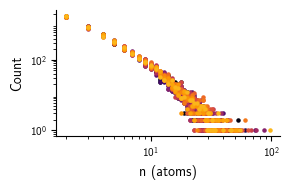

In [9]:
fig, ax = plt.subplots(figsize=(3.0, 2.0))

norm = plt.Normalize(0, 150)
cmap = lambda x: cm.inferno(norm(x))

for i in range(0, 130, 5):
    n = cnt[i]

    size = np.arange(np.max(n) + 1)
    dist = np.bincount(n)

    mask = dist > 0
    ax.scatter(size[mask], dist[mask], color=cmap(i), s=5)

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("n (atoms)")
ax.set_ylabel("Count")

ax.set_yticks([1e0, 1e2])
# savefig(fig, "03-solid-cnt.pdf")
fig.tight_layout()
plt.show()

## Using classical nucleation theory to describe the results

In [10]:
Nav = 6.02e23  # atoms/mol
molar_mass = 63.546e-3 # kg/mol
density = 8.96e3 # kg/m^3
density = density / (molar_mass / Nav)  # atoms/m^3
vol = 12.8e-30  # m^3
kb1 = 8.314e-3  # kJ/mol K
kb = 1.380649e-23  # J/K
T = 917

def size_fn(x, x0, dG, gamma):
#     v = x * vol
    z = x / density
    r = np.power(3 * z / (4 * np.pi), 1 / 3)
    kT = kb * T
    b = -dG / kT * (4 * np.pi / 3)
    c = -gamma / kT * (4 * np.pi)
    
    return x0 + b * r**3 + c * r**2

In [11]:
params_temp = {}
step = 120

for min_time in np.arange(0, 1):
    all_x, all_y = [], []
    for i in range(min_time * step, min_time * step + step):
        n = cnt[i]

        size = np.arange(np.amax(n) + 1)
        dist = np.bincount(n)
        mask = (dist > 0)# & (size < 20)

        all_x += [size[mask]]
        all_y += [dist[mask]]

    all_x = np.concatenate(all_x)
    all_y = np.concatenate(all_y)

    params, _ = curve_fit(
        size_fn,
        all_x, np.log(all_y),
        p0=[7, -4, 0.2],
        bounds=([0, -np.inf, 0], [np.inf, 0, np.inf])
    )
    
    params_temp[min_time] = params

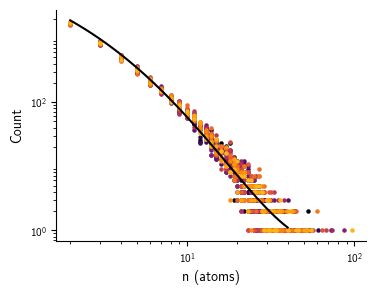

In [12]:
fig, ax = plt.subplots(figsize=(4.0, 3.0))

norm = plt.Normalize(0, 150)
cmap = lambda x: cm.inferno(norm(x))

for i in range(0, 130, 5):
    n = cnt[i]

    size = np.arange(np.max(n) + 1)
    dist = np.bincount(n)

    mask = dist > 0
    ax.scatter(size[mask], dist[mask], color=cmap(i), s=5)

_x = np.logspace(np.log10(2), np.log10(40))
_y = np.exp(size_fn(_x, *params_temp[0]))
ax.plot(_x, _y, color="k")
    
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("n (atoms)")
ax.set_ylabel("Count")

ax.set_yticks([1e0, 1e2])
# savefig(fig, "03-solid-cnt.pdf")

plt.show()